### 데이터사이언스 프로젝트 - 4조  
# 주제 : 자전거 사고다발지점 데이터 및 문제점 분석

## 0. 배경 및 목적

### -  배경
   - <u>**자전거 교통사고의 지속적인 증가**</u>
   <br>도로교통공단에서 조사한 자전거 교통사고 추세에 따르면 **2018년부터 2020년까지 전체교통사고 중 자전거사고의 점유율이 꾸준히 올랐다.** 또한, 전체교통사고 중 가장 위험도가 높은 **자전거사고 사망자수의 점유율은 같은 기간 5.5%에서 6.4%로 약 0.9% 올랐다.**


![2021년(2020년 기준)자전거 이용 현황](https://kin-phinf.pstatic.net/20220516_186/1652687852954XTXoY_PNG/2222.png?type=w750)

   - <u>**이용자의 높은 자전거 교통사고 과실율**</u>
   <br>최근에는 쿠팡이츠, 배달의 민족 등의 **배달 플랫폼에서 자전거를 배달수단으로 이용하면서 관련 자전거 사고가 발생하고 있다.** 하지만, 대부분의 자전거 배달 노동자는 보험금은 받을 수 없는 시스템으로 이루어져 있어 **본인이 과실을 온전히 책임져야한다.**<br>


![쿠팡이츠 배달원 사망사고](https://img.khan.co.kr/news/2020/09/18/l_2020091801002227000175352.jpg)

<u>**&rarr; 자전거 교통사고 대책 중요성 증가**</u>

### -  목적
   - 자전거 교통사고 데이터를 기반으로 자전거 교통사고가 많이 발생하는 위치, 발생하는 요인 등을 분석하여 **실생활 자전거 이용시 주의해야할 점을 숙고하고자 한다.**  


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# 필요없는 경고창 무시
warnings.simplefilter("ignore")

# 한글폰트
import matplotlib.font_manager as fonm
plt.rc('font', family='Malgun Gothic') # For Windows

## 1. 데이터 수집 및 전처리
 - 데이터는 TMACS에서 기본적으로 제공하는 전국 사고다발지점 데이터와 각 구간별 세부정보 데이터를 크롤링해서 사용하였다

### 1.1 자전거 사고다발지점 데이터
- 2018~2020년 전국 자전거 사고다발지점, 사망, 부상, 경상, 부상사고 건수 및 인원수
- 사고다발지점 기준은 각 지역별로 과거 3년간(기준년도 포함) 반경 50m 이내, 2건 이상 발생한 상위 30개 지점
- 교통안전정보관리시스템 제공 자전거사고 현황
    <br> 출처 : https://tmacs.kotsa.or.kr/web/TG/TG300/TG3200/Tg3200_34.jsp?mid=S1814#-자전거<br>

#### 1.1.1 각 지역 데이터 통합작업
- 데이터가 각 광역시/도 별 기준으로만 다운로드 받을 수 밖에 없어서 17개의 데이터를 다운로드하고 합쳐주는 작업

In [123]:
# 데이터 로드

cities = ['강원','경기','경남','경북','광주','대구','대전','부산','서울','세종','울산','인천','전남','전북','제주','충남','충북']
df = pd.DataFrame()
for city in cities:
    tmp = pd.read_excel(f"data/original_data/교통약자다발지점 사고지표-{city}.xlsx", header = 2)
    # 마지막 합계 row 삭제
    tmp.drop(tmp.index[-1], inplace=True)
    # 이제까지 합쳐온 데이터프레임과 새로 로드한 데이터프레임을 합쳐줌
    df = pd.concat([df, tmp], ignore_index=True,)


In [3]:
# 필요없는 column을 삭제해주고 colname 변경
# 우선 사망자수 기준으로 데이터를 살펴볼 예정이므로 건수 관련 col 삭제
# df.drop(['사망', '중상','경상', '부상'], axis=1, inplace=True)

#colname 변경
df.rename(columns = {
                    'Unnamed: 2' : '지점명', 
                    "사망": "사망(건)",
                    "중상" : "중상(건)",
                    "경상" : "경상(건)",
                    "부상" : "부상(건)",
                    "대형\n사고" : "대형사고",
                    "사망.1": "사망(명)",
                    "중상.1" : "중상(명)",
                    "경상.1" : "경상(명)",
                    "부상.1" : "부상(명)",
                    "Unnamed: 13" : "치사율(%)"
}, inplace = True)

In [4]:
# 전국 데이터셋으로 합쳐놓은 DataFrame 저장
df.to_excel('revised_data/교통약자다발지점_사고지표_전국.xlsx', index=False)

### 1.2 크롤링한 데이터 
- 각 구간별로 세부정보(법규위반, 시간대, 기상상태) 등을 알기 위함



In [2]:
# 크롤링 데이터 로드
# 크롤링한 데이터 또한 위의 사고현황 데이터와 같이 결측값 처리 완료
# 지점명이 없는 경우(혹은 null)는 강릉시1, 강릉시2처럼 (기초) + (순번) 형식으로 입력해줌
crawler_df = pd.read_excel("data/crawler_data/세부정보_결측값처리.xlsx")
crawler_df

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,새벽,출퇴근,주간,심야,맑음,흐림,비,안개,눈,기타.2
0,서울,강남구,서울대청초등학교 부근(북동),0,0,0,0,0,0,0,...,0,2,1,0,2,0,1,0,0,0
1,서울,강남구,수서역 부근 삼거리(북쪽),0,0,0,0,0,0,0,...,1,0,1,0,2,0,0,0,0,0
2,서울,강남구,성수대교 남단 사거리,1,0,0,0,0,0,0,...,0,1,1,0,2,0,0,0,0,0
3,서울,강남구,삼성교사거리(서단),0,0,0,0,0,0,0,...,0,2,2,0,4,0,0,0,0,0
4,서울,강남구,삼성골든빌아파트 앞 삼거리,0,0,0,0,0,0,0,...,0,2,2,0,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,제주,제주시,월성사거리(국제공항 동쪽),1,0,0,0,0,1,0,...,0,1,0,1,2,0,0,0,0,0
2642,제주,제주시,제주시1,1,0,0,0,0,0,0,...,0,1,1,0,2,0,0,0,0,0
2643,제주,제주시,국립박물관사거리,0,0,0,0,0,0,0,...,0,0,2,0,2,0,0,0,0,0
2644,제주,제주시,CGV 앞 사거리(북서),0,2,0,0,0,0,0,...,0,0,2,0,2,0,0,0,0,0


In [6]:
#결측값 없음 확인
crawler_df.isna().sum()

광역         0
기초         0
지점명        0
사업용        0
비사업용       0
기타         0
중앙선침범      0
신호위반       0
안전거리미확보    0
불법유턴       0
과속         0
안전운전불이행    0
교차로위반      0
보행자보호위반    0
차로위반       0
직진우회전방해    0
기타.1       0
봄          0
여름         0
가을         0
겨울         0
새벽         0
출퇴근        0
주간         0
심야         0
맑음         0
흐림         0
비          0
안개         0
눈          0
기타.2       0
dtype: int64

#### 1.2.1 지점명 통일
   - **같은 지점명을 기준으로 합치기 위해서 지점명 완전하게 통일하는 작업 필요**


In [7]:
# 크롤링한 세부정보 데이터에도 건수의 합을 나타내는 열 추가
crawler_df['건수'] = crawler_df.iloc[:, -6:].sum(axis=1)
crawler_df

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,출퇴근,주간,심야,맑음,흐림,비,안개,눈,기타.2,건수
0,서울,강남구,서울대청초등학교 부근(북동),0,0,0,0,0,0,0,...,2,1,0,2,0,1,0,0,0,3
1,서울,강남구,수서역 부근 삼거리(북쪽),0,0,0,0,0,0,0,...,0,1,0,2,0,0,0,0,0,2
2,서울,강남구,성수대교 남단 사거리,1,0,0,0,0,0,0,...,1,1,0,2,0,0,0,0,0,2
3,서울,강남구,삼성교사거리(서단),0,0,0,0,0,0,0,...,2,2,0,4,0,0,0,0,0,4
4,서울,강남구,삼성골든빌아파트 앞 삼거리,0,0,0,0,0,0,0,...,2,2,0,4,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,제주,제주시,월성사거리(국제공항 동쪽),1,0,0,0,0,1,0,...,1,0,1,2,0,0,0,0,0,2
2642,제주,제주시,제주시1,1,0,0,0,0,0,0,...,1,1,0,2,0,0,0,0,0,2
2643,제주,제주시,국립박물관사거리,0,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2
2644,제주,제주시,CGV 앞 사거리(북서),0,2,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2


In [8]:
#원활한 비교를 위해 광역, 기초, 지점명 순으로 정렬해주자

df = pd.read_excel('revised_data/교통약자다발지점_사고지표_전국_결측값처리.xlsx')

crawler_df_sorted = crawler_df.sort_values(by=['광역', '기초', '지점명', '건수']).reset_index(drop=True)
df_sorted = df.sort_values(by=['광역', '기초', '지점명', '건수']).reset_index(drop=True)

In [9]:
# 지점명이 다른 경우가 14개가 보인다. 
# 같아 보이지만, 띄어쓰기 차이 등 차이가 있어 기존 데이터의 지점명 주소를 기준으로 통일해주자
condition = (crawler_df_sorted['지점명'] != df_sorted['지점명'])
df_sorted[condition]

,광역,기초,지점명,건수,사망(건),중상(건),경상(건),부상(건),대형사고,사망(명),중상(명),경상(명),부상(명),치사율(%)
69,경기,고양시,종로한강다목적경기장 옆 자전거도로 덕은동 종로한강다목적경,2,0,2,0,0,0,0,2,0,0,0.0
336,경기,안산시,제일제강공업 사거리,2,1,0,1,0,0,1,0,1,0,50.0
406,경기,여주시,경기도 여주시 주내로 31 투썸플레이스 여주강변점 입구,2,0,2,0,0,0,0,2,0,0,0.0
534,경기,하남시,경기도 하남시 선동 287-1 미사리 선동 축구장 옆 자전거도로(,3,0,1,1,1,0,0,1,3,2,0.0
798,경북,문경시,우리공인중계사 앞 노상,3,0,2,1,0,0,0,2,1,0,0.0
1498,서울,강남구,영동대교 남단 삼거리,2,0,0,2,0,0,0,0,2,0,0.0
1637,서울,광진구,서울특별시 광진구 자양동 571-1 잠실대교 북단 수중보 자전거,2,0,1,1,0,0,0,1,1,0,0.0
2060,서울,용산구,서울특별시 용산구 양녕로 496 이촌로 302 이촌한강공원 보행,2,0,1,1,0,0,0,1,1,0,0.0
2301,인천,연수구,글로벌캠퍼스푸르지오 102동 앞 횡단보도,2,0,1,1,0,0,0,1,1,0,0.0
2353,전남,무안군,전라남도 무안군 일로읍 청호리 584 사고장소는 상사바위길 101,2,0,1,1,0,0,0,2,1,0,0.0


In [10]:
crawler_df_sorted[condition]

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,출퇴근,주간,심야,맑음,흐림,비,안개,눈,기타.2,건수
69,경기,고양시,종로한강다목적경기장 옆 자전거도로 덕은동 종로한강다목적경,0,0,0,0,0,0,0,...,1,1,0,2,0,0,0,0,0,2
336,경기,안산시,제일제강공업 사거리,0,1,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,2
406,경기,여주시,경기도 여주시 주내로 31 투썸플레이스 여주강변점 입구,0,2,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2
534,경기,하남시,경기도 하남시 선동 287-1 미사리 선동 축구장 옆 자전거도로(,0,0,0,0,0,0,0,...,0,3,0,3,0,0,0,0,0,3
798,경북,문경시,우리공인중계사 앞 노상,0,3,0,0,0,0,0,...,0,3,0,3,0,0,0,0,0,3
1498,서울,강남구,영동대교 남단 삼거리,1,0,0,0,1,0,0,...,0,0,2,2,0,0,0,0,0,2
1637,서울,광진구,서울특별시 광진구 자양동 571-1 잠실대교 북단 수중보 자전거,0,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2
2060,서울,용산구,서울특별시 용산구 양녕로 496 이촌로 302 이촌한강공원 보행,0,0,0,1,0,0,0,...,0,2,0,2,0,0,0,0,0,2
2301,인천,연수구,글로벌캠퍼스푸르지오 102동 앞 횡단보도,0,1,0,0,1,0,0,...,0,1,1,2,0,0,0,0,0,2
2353,전남,무안군,전라남도 무안군 일로읍 청호리 584 사고장소는 상사바위길 101,0,1,0,1,0,0,0,...,0,2,0,2,0,0,0,0,0,2


In [11]:
# 실제로 다르다는 것을 확인할 수 있음
print(df_sorted[condition].iloc[0]['지점명'])
print(crawler_df_sorted[condition].iloc[0]['지점명'])

종로한강다목적경기장 옆 자전거도로 덕은동  종로한강다목적경
종로한강다목적경기장 옆 자전거도로 덕은동 종로한강다목적경


In [12]:
df_sorted[condition].index

Int64Index([69, 336, 406, 534, 798, 1498, 1637, 2060, 2301, 2353, 2362, 2394,
            2420, 2472],
           dtype='int64')

In [13]:
crawler_df_sorted.iloc[crawler_df_sorted[condition].index]['지점명']

69             종로한강다목적경기장 옆 자전거도로 덕은동 종로한강다목적경
336                                 제일제강공업 사거리
406             경기도 여주시 주내로 31 투썸플레이스 여주강변점 입구
534       경기도 하남시 선동 287-1 미사리 선동 축구장 옆 자전거도로(
798                               우리공인중계사 앞 노상
1498                               영동대교 남단 삼거리
1637       서울특별시 광진구 자양동 571-1 잠실대교 북단 수중보 자전거
2060       서울특별시 용산구 양녕로 496 이촌로 302 이촌한강공원 보행
2301                    글로벌캠퍼스푸르지오 102동 앞 횡단보도
2353      전라남도 무안군 일로읍 청호리 584 사고장소는 상사바위길 101
2362    전라남도 순천시 해룡면 신대리 2156 신대 생태회랑6교 앞 (-->
2394                          구암휴먼시아 105동 앞 도로
2420                전라북도 남원시 만인로 59 버스정류장 앞 노상
2472                        송령교 앞 사거리 송령교앞 사거리
Name: 지점명, dtype: object

In [14]:
df_sorted.iloc[df_sorted[condition].index]['지점명'].tolist()

['종로한강다목적경기장 옆 자전거도로 덕은동  종로한강다목적경',
 '제일제강공업  사거리',
 '경기도 여주시 주내로 31 투썸플레이스 여주강변점  입구',
 '경기도 하남시 선동 287-1 미사리 선동 축구장 옆  자전거도로(',
 '우리공인중계사  앞 노상',
 '영동대교  남단 삼거리',
 '서울특별시 광진구 자양동 571-1 잠실대교  북단 수중보 자전거',
 '서울특별시 용산구 양녕로 496 이촌로 302  이촌한강공원  보행',
 '글로벌캠퍼스푸르지오 102동 앞  횡단보도',
 '전라남도 무안군 일로읍 청호리 584 사고장소는  상사바위길 101',
 '전라남도 순천시 해룡면 신대리 2156 신대 생태회랑6교 앞 (--)',
 '구암휴먼시아  105동 앞 도로',
 '전라북도 남원시 만인로 59 버스정류장  앞 노상',
 '송령교 앞 사거리 송령교앞  사거리']

In [15]:
crawler_df_sorted.iloc[crawler_df_sorted[condition].index, 2] = df_sorted.iloc[df_sorted[condition].index]['지점명']

In [16]:
crawler_df_sorted.iloc[crawler_df_sorted[condition].index]['지점명']

69            종로한강다목적경기장 옆 자전거도로 덕은동  종로한강다목적경
336                                제일제강공업  사거리
406            경기도 여주시 주내로 31 투썸플레이스 여주강변점  입구
534      경기도 하남시 선동 287-1 미사리 선동 축구장 옆  자전거도로(
798                              우리공인중계사  앞 노상
1498                              영동대교  남단 삼거리
1637      서울특별시 광진구 자양동 571-1 잠실대교  북단 수중보 자전거
2060     서울특별시 용산구 양녕로 496 이촌로 302  이촌한강공원  보행
2301                   글로벌캠퍼스푸르지오 102동 앞  횡단보도
2353     전라남도 무안군 일로읍 청호리 584 사고장소는  상사바위길 101
2362    전라남도 순천시 해룡면 신대리 2156 신대 생태회랑6교 앞 (--)
2394                         구암휴먼시아  105동 앞 도로
2420               전라북도 남원시 만인로 59 버스정류장  앞 노상
2472                       송령교 앞 사거리 송령교앞  사거리
Name: 지점명, dtype: object

In [17]:
# 처리 후 두 df 사이 지점명이 다른 것이 하나도 없는 것을 확인할 수 있다
(crawler_df_sorted['지점명'] != df_sorted['지점명']).value_counts()

False    2646
Name: 지점명, dtype: int64

In [18]:
# # 최종으로 지점명 통일한 파일로 테이블 내보내기
# crawler_df_sorted.to_excel("./세부정보_결측값처리_지점명통일.xlsx", index=False)
# df_sorted.to_excel("./교통약자다발지점_사고지표_전국_결측값처리_지점명통일.xlsx", index=False)

### 1.3 데이터 합치기
   - **지점명이 완전히 통일된 사고현황 데이터와 크롤링한 세부정보 데이터 합치기**



In [19]:
crawler_df_sorted[crawler_df_sorted.duplicated(['지점명'])==True] #중복이 되는 데이터들만 보기

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,출퇴근,주간,심야,맑음,흐림,비,안개,눈,기타.2,건수
16,강원,원주시,원주중학교 오거리(북서),0,2,0,0,0,0,0,...,1,1,0,2,0,0,0,0,0,2
83,경기,과천시,소방서삼거리(과천소방서),1,1,0,0,1,0,0,...,1,2,0,3,0,0,0,0,0,3
92,경기,광명시,광명사거리역 부근(서쪽),0,2,0,1,1,0,0,...,1,2,1,4,0,0,0,0,0,4
110,경기,광명시,휴먼시아1단지 앞 삼거리(101동),0,1,0,0,1,0,0,...,2,0,0,2,0,0,0,0,0,2
180,경기,남양주시,연평교차로(연평대교북단),1,0,0,0,0,0,0,...,1,1,0,2,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,충북,청주시,현대2차아파트 사거리(214동),1,1,0,1,0,0,0,...,0,1,2,2,0,1,0,0,0,3
2624,충북,충주시,법원사거리 부근(남쪽),0,1,0,0,0,0,0,...,1,1,0,2,0,0,0,0,0,2
2627,충북,충주시,삼원로터리(삼원초 앞),0,1,0,0,1,0,0,...,1,1,0,2,0,0,0,0,0,2
2628,충북,충주시,삼원로터리(삼원초 앞),1,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2


크롤링한 데이터 지점명 변경

In [20]:
count = 0
for idx in crawler_df_sorted.index:
    loc_arr = crawler_df_sorted[(crawler_df_sorted['광역']==crawler_df_sorted.loc[idx]['광역']) & (crawler_df_sorted['기초']==crawler_df_sorted.loc[idx]['기초'])&(crawler_df_sorted['지점명']==crawler_df_sorted.loc[idx]['지점명'])].index
    num=1
    if len(loc_arr)>=2:
        for location in loc_arr:
            # print("바뀌기 전",crawler_df_sorted.loc[location]['지점명'])
            crawler_df_sorted.loc[location, '지점명'] = f"{crawler_df_sorted.loc[location]['지점명']} - {num}"
            num+=1
            # print("바꾼 후 ",crawler_df_sorted.loc[location]['지점명'])
            count += 1
print(f'총 {count}개 변경 완료')

총 362개 변경 완료


기존 데이터 지점명 변경

In [21]:
df_sorted[df_sorted.duplicated(['지점명'])==True] #중복이 되는 데이터들만 보기

,광역,기초,지점명,건수,사망(건),중상(건),경상(건),부상(건),대형사고,사망(명),중상(명),경상(명),부상(명),치사율(%)
16,강원,원주시,원주중학교 오거리(북서),2,0,0,2,0,0,0,0,2,0,0.000000
83,경기,과천시,소방서삼거리(과천소방서),3,1,0,1,1,0,1,0,1,1,33.333333
92,경기,광명시,광명사거리역 부근(서쪽),4,0,1,2,1,0,0,1,2,1,0.000000
110,경기,광명시,휴먼시아1단지 앞 삼거리(101동),2,0,1,0,1,0,0,1,0,1,0.000000
180,경기,남양주시,연평교차로(연평대교북단),2,0,1,1,0,0,0,1,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,충북,청주시,현대2차아파트 사거리(214동),3,0,0,3,0,0,0,0,3,0,0.000000
2624,충북,충주시,법원사거리 부근(남쪽),2,0,0,2,0,0,0,0,2,0,0.000000
2627,충북,충주시,삼원로터리(삼원초 앞),2,0,1,0,1,0,0,1,0,1,0.000000
2628,충북,충주시,삼원로터리(삼원초 앞),2,0,0,2,0,0,0,0,2,0,0.000000


In [22]:
df_sorted[(df_sorted['광역']==df_sorted.loc[idx]['광역']) & (df_sorted['기초']==df_sorted.loc[idx]['기초'])&(df_sorted['지점명']==df_sorted.loc[idx]['지점명'])].index

Int64Index([2645], dtype='int64')

In [23]:
count = 0
for idx in df_sorted.index:
    loc_arr = df_sorted[(df_sorted['광역']==df_sorted.loc[idx]['광역']) & (df_sorted['기초']==df_sorted.loc[idx]['기초'])&(df_sorted['지점명']==df_sorted.loc[idx]['지점명'])].index
    num=1
    if len(loc_arr)>=2:
        for location in loc_arr:
            # print("바뀌기 전",origin.loc[location]['지점명'])
            df_sorted.loc[location, '지점명'] = f"{df_sorted.loc[location]['지점명']} - {num}"
            num+=1
            # print("바꾼 후 ",origin.loc[location]['지점명'])
            count += 1
print(f'총 {count}개 변경 완료')

총 362개 변경 완료


In [24]:
df_sorted[df_sorted['지점명']=='자전거도로']

,광역,기초,지점명,건수,사망(건),중상(건),경상(건),부상(건),대형사고,사망(명),중상(명),경상(명),부상(명),치사율(%)
942,광주,광산구,자전거도로,2,0,0,2,0,0,0,0,2,0,0.0
1651,서울,광진구,자전거도로,2,0,1,1,0,0,0,1,1,0,0.0
1816,서울,동작구,자전거도로,3,0,1,1,1,0,0,1,1,3,0.0
2047,서울,영등포구,자전거도로,5,0,2,3,0,0,0,2,3,0,0.0


In [25]:
df_sorted[df_sorted.duplicated(['지점명'])==True] #중복이 되는 데이터들만 보기

,광역,기초,지점명,건수,사망(건),중상(건),경상(건),부상(건),대형사고,사망(명),중상(명),경상(명),부상(명),치사율(%)
968,광주,동구,양림교 동단 사거리,2,0,1,1,0,0,0,1,1,0,0.0
1214,대구,중구,대봉교 서단 사거리,2,0,1,1,0,0,0,1,2,0,0.0
1260,대전,동구,중리네거리(용전동주민센터 북쪽),2,0,2,0,0,0,0,2,0,0,0.0
1651,서울,광진구,자전거도로,2,0,1,1,0,0,0,1,1,0,0.0
1669,서울,구로구,디지털단지입구(미성1동 동쪽) - 1,3,0,1,1,1,0,0,1,1,1,0.0
1670,서울,구로구,디지털단지입구(미성1동 동쪽) - 2,3,0,0,2,1,0,0,0,2,1,0.0
1705,서울,금천구,하안남초교 삼거리,2,0,0,2,0,0,0,0,2,1,0.0
1816,서울,동작구,자전거도로,3,0,1,1,1,0,0,1,1,3,0.0
1817,서울,동작구,자전거도로 자전거도로,3,0,1,0,2,0,0,1,0,3,0.0
1905,서울,서초구,한남남단I.C(동쪽),2,0,0,1,1,0,0,0,1,1,0.0


두 데이터의 지점명 일치하는지 확인

In [26]:
for loc,cnt in enumerate(df['지점명']):
    cnt=0
    if df_sorted.loc[idx]['지점명']!=crawler_df_sorted.loc[idx]['지점명']:
        cnt+=1
print(cnt)

0


In [27]:
# 두 데이터 병합
merged_data = pd.merge(crawler_df_sorted, df_sorted, how = 'inner', on = ['광역', '기초', '지점명', '건수'])

In [28]:
merged_data.columns

Index(['광역', '기초', '지점명', '사업용', '비사업용', '기타', '중앙선침범', '신호위반', '안전거리미확보',
       '불법유턴', '과속', '안전운전불이행', '교차로위반', '보행자보호위반', '차로위반', '직진우회전방해', '기타.1',
       '봄', '여름', '가을', '겨울', '새벽', '출퇴근', '주간', '심야', '맑음', '흐림', '비', '안개',
       '눈', '기타.2', '건수', '사망(건)', '중상(건)', '경상(건)', '부상(건)', '대형사고', '사망(명)',
       '중상(명)', '경상(명)', '부상(명)', '치사율(%)'],
      dtype='object')

올바르게 병합되어 있는지 확인

In [29]:
for loc,cnt in enumerate(df_sorted['건수']):
    cnt=0
    if merged_data.loc[idx]['봄']+merged_data.loc[idx]['여름']+\
        merged_data.loc[idx]['가을']+merged_data.loc[idx]['겨울']!=df_sorted.loc[idx]['건수']:
        cnt+=1
print(cnt)

0


In [30]:
for loc,cnt in enumerate(crawler_df_sorted['건수']):
    cnt=0
    if merged_data.loc[idx]['봄']+merged_data.loc[idx]['여름']+\
        merged_data.loc[idx]['가을']+merged_data.loc[idx]['겨울']!=crawler_df_sorted.loc[idx]['건수']:
        cnt+=1
print(cnt)

0


컬럼명 바꾸기

In [31]:
merged_data.rename(columns={'기타.1':'법규-기타','기타.2':'기상-기타'}, inplace=True) # 안됨 => 이유 모르겠음

In [32]:
merged_data.columns

Index(['광역', '기초', '지점명', '사업용', '비사업용', '기타', '중앙선침범', '신호위반', '안전거리미확보',
       '불법유턴', '과속', '안전운전불이행', '교차로위반', '보행자보호위반', '차로위반', '직진우회전방해', '법규-기타',
       '봄', '여름', '가을', '겨울', '새벽', '출퇴근', '주간', '심야', '맑음', '흐림', '비', '안개',
       '눈', '기상-기타', '건수', '사망(건)', '중상(건)', '경상(건)', '부상(건)', '대형사고', '사망(명)',
       '중상(명)', '경상(명)', '부상(명)', '치사율(%)'],
      dtype='object')

In [33]:
merged_data.to_excel('data/final_data/교통약자다발지점_사고지표_세부정보_병합.xlsx', index=False)

## 2. 데이터 탐색(EDA)

In [1]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [7]:
df = pd.read_excel('data/final_data/교통약자다발지점_사고지표_세부정보_병합.xlsx')
df

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,사망(건),중상(건),경상(건),부상(건),대형사고,사망(명),중상(명),경상(명),부상(명),치사율(%)
0,강원,강릉시,강릉시1,0,2,0,0,0,0,0,...,0,2,0,0,0,0,2,0,0,0.000000
1,강원,강릉시,강릉시2,2,0,0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0.000000
2,강원,강릉시,로얄아파트 부근 사거리(동쪽),1,1,0,0,0,0,0,...,0,1,1,1,0,0,1,1,1,0.000000
3,강원,강릉시,성남동 99-9번지,0,2,0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0.000000
4,강원,강릉시,스카이베이호텔 부근 도로,0,0,0,0,0,0,0,...,0,2,0,0,0,0,2,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,충북,충주시,충주시립도서관 앞 사거리(동쪽),0,1,0,0,0,1,0,...,0,1,3,0,0,0,1,3,1,0.000000
2642,충북,충주시,충주종합운동장(남서),0,2,0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0.000000
2643,충북,충주시,칠금동 327-2번지,0,2,0,0,0,0,0,...,1,0,2,0,0,1,0,2,0,33.333333
2644,충북,충주시,칠금초교 북동 사거리,0,2,0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0.000000


In [8]:
#NaN값 확인
df.isna().sum()

광역         0
기초         0
지점명        0
사업용        0
비사업용       0
기타         0
중앙선침범      0
신호위반       0
안전거리미확보    0
불법유턴       0
과속         0
안전운전불이행    0
교차로위반      0
보행자보호위반    0
차로위반       0
직진우회전방해    0
법규-기타      0
봄          0
여름         0
가을         0
겨울         0
새벽         0
출퇴근        0
주간         0
심야         0
맑음         0
흐림         0
비          0
안개         0
눈          0
기상-기타      0
건수         0
사망(건)      0
중상(건)      0
경상(건)      0
부상(건)      0
대형사고       0
사망(명)      0
중상(명)      0
경상(명)      0
부상(명)      0
치사율(%)     0
dtype: int64

In [9]:
# 대형사고는 다 0이기 때문에 column 삭제
df.drop(['대형사고'], axis=1, inplace=True)
df

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
0,강원,강릉시,강릉시1,0,2,0,0,0,0,0,...,2,0,2,0,0,0,2,0,0,0.000000
1,강원,강릉시,강릉시2,2,0,0,0,0,0,0,...,2,0,1,1,0,0,1,1,0,0.000000
2,강원,강릉시,로얄아파트 부근 사거리(동쪽),1,1,0,0,0,0,0,...,3,0,1,1,1,0,1,1,1,0.000000
3,강원,강릉시,성남동 99-9번지,0,2,0,0,0,0,0,...,2,0,1,1,0,0,1,1,0,0.000000
4,강원,강릉시,스카이베이호텔 부근 도로,0,0,0,0,0,0,0,...,2,0,2,0,0,0,2,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,충북,충주시,충주시립도서관 앞 사거리(동쪽),0,1,0,0,0,1,0,...,4,0,1,3,0,0,1,3,1,0.000000
2642,충북,충주시,충주종합운동장(남서),0,2,0,0,0,0,0,...,2,0,1,1,0,0,1,1,0,0.000000
2643,충북,충주시,칠금동 327-2번지,0,2,0,0,0,0,0,...,3,1,0,2,0,1,0,2,0,33.333333
2644,충북,충주시,칠금초교 북동 사거리,0,2,0,0,0,0,0,...,2,0,1,1,0,0,1,1,0,0.000000


### 2.1 사고 건수 분석

In [10]:
df_accident = df.loc[:, ['광역', '기초','지점명', '건수', '사망(건)', '중상(건)', '경상(건)', '부상(건)',
                        '사망(명)', '중상(명)','경상(명)', '부상(명)', '치사율(%)']]
df_accident

,광역,기초,지점명,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
0,강원,강릉시,강릉시1,2,0,2,0,0,0,2,0,0,0.000000
1,강원,강릉시,강릉시2,2,0,1,1,0,0,1,1,0,0.000000
2,강원,강릉시,로얄아파트 부근 사거리(동쪽),3,0,1,1,1,0,1,1,1,0.000000
3,강원,강릉시,성남동 99-9번지,2,0,1,1,0,0,1,1,0,0.000000
4,강원,강릉시,스카이베이호텔 부근 도로,2,0,2,0,0,0,2,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,충북,충주시,충주시립도서관 앞 사거리(동쪽),4,0,1,3,0,0,1,3,1,0.000000
2642,충북,충주시,충주종합운동장(남서),2,0,1,1,0,0,1,1,0,0.000000
2643,충북,충주시,칠금동 327-2번지,3,1,0,2,0,1,0,2,0,33.333333
2644,충북,충주시,칠금초교 북동 사거리,2,0,1,1,0,0,1,1,0,0.000000


#### 2.1.1 가장 건수가 많은 Top 10 
   - **건수를 기준으로 내림차순으로 정렬하여 건수 상위 10개까지 확인**


In [11]:
df_accident.nlargest(10, ['건수']) #가장 건수가 많은 top 10

,광역,기초,지점명,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
236,경기,성남시,모란사거리(모란역) - 3,10,0,4,4,2,0,4,4,2,0.0
1734,서울,노원구,창동교 동단 사거리 - 2,9,0,1,6,2,0,1,6,2,0.0
2055,서울,영등포구,한강자전거도로(안양천합수부),9,0,4,3,2,0,4,4,2,0.0
2031,서울,영등포구,부근 한강자전거 도로,8,0,2,3,3,0,2,5,4,0.0
2054,서울,영등포구,한강자전거도로 자전거도로,8,0,3,5,0,0,4,8,1,0.0
2137,서울,중랑구,면목2동사거리(삼성교회) - 2,8,0,2,4,2,0,2,4,2,0.0
152,경기,김포시,윈스스템즈빌딩사거리,7,0,3,2,2,0,3,2,2,0.0
274,경기,수원시,수원화성박물관 부근(서쪽),7,0,1,4,2,0,1,5,2,0.0
755,경북,경주시,팔우정삼거리(경주역 남쪽) - 2,7,0,3,3,1,0,3,3,1,0.0
1511,서울,강동구,길동 사거리(휴다임타워),7,0,4,3,0,0,4,3,0,0.0


- 자전거 도로와 사거리, 삼거리 등의 교차로가 높은 순위에 있음을 알 수 있다.
- 특히, 자전거를 탑승하기에 안전하다고 인식되는 자전거도로가 3,4,5위에 있다.

#### 2.2.2 텍스트 빈도분석 및 wordCloud

In [12]:
#워드 클라우드
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import numpy as np
import re

In [13]:
# 각 line들을 합쳐주는 함수 작성
def flatten(l):
    flatList = []
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList

In [14]:
def find_stopwords(word, stopwords):
    for stop in stopwords_korean:
        # 하나라도 발견 되면
        if  word.find(stop) >= 0:
            word = word.replace(stop, "")
    return word
        

In [15]:
temp_split = []
for idx in range(len(df)):
    line = df['지점명'][idx]
    
    # 자전거 도로 -> 자전거도로
    if '자전거 도로' in line:
        line = line.replace('자전거 도로', '자전거도로')
    nouns = line.split()
    temp_split.append(nouns)
print(len(temp_split))


2646


In [16]:
word_list2 = flatten(temp_split)
len(word_list2)

7609

In [17]:
stopwords_korean = ['부근', '서울특별시', '전라남도','전라북도', '경상남도', '경상북도','충청남도','충청북도','경기도',
                    '대구광역시', '울산광역시', '부산광역시', '인천광역시', '광주광역시','세종특별자치시',
                    '경기', '동쪽', '서쪽', '남쪽', '북쪽',
                    '동서', '동남', '동북', 
                    '서동', '서남', '서북',
                    '남동', '남서',
                    '북서', '북동',
                    '동단', '서단', '남단', '북단',
                    '번지']

In [18]:
# 1차 - 불용어 리스트를 활용해 제거
word_list_temp = []
for word in word_list2:
    
    new_word = find_stopwords(word, stopwords_korean)
    word_list_temp.append(new_word)
        

# 2차 - 숫자 제거
r_number = re.compile('[0-9]+')
word_list2 = [r_number.sub('', i) for i in word_list_temp]

# 3차 - 특수문자 제거
r_special = re.compile('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]')
word_list2 = [r_special.sub('', i) for i in word_list2]


# 4차 - 한자리 글자(불용어) 제거
word_list2 = [i for i in word_list2 if len(i)>1]
# word_list



In [19]:
pd.DataFrame(word_list2).value_counts()[:50]

사거리           659
삼거리           307
교차로            78
자전거도로          72
앞동             53
노상             40
사거리동           38
도로             37
횡단보도           26
삼거리동           26
오거리            22
사거리번출구         17
번출구            17
입구             13
남양주시           11
우체국            10
주민센터            9
삼거리번출구          9
한강자전거도로         9
정문              8
도로상             8
자전거             7
현대아파트           7
한강공원            7
강동구             7
김포시             7
이마트             6
세종시             6
하남시             6
한강대교            6
주차장             6
자전거도로상          6
남구              6
반포대교            5
탄천              5
버스정류장           5
동구              5
대전광역시           5
강서구             5
네거리             5
출구              5
홈플러스            5
디지털단지입구미성동      4
강남구             4
세븐일레븐           4
서초구             4
암사동             4
함안군             4
로터리             4
구미시             4
dtype: int64

In [20]:
# font_path = "./wordcloud_data/BMDOHYEON_ttf.ttf"
# font_path = "./wordcloud_data/Binggrae-Bold.ttf"
# font_path = "./wordcloud_data/배스킨라빈스 B.ttf"
# font_path = "./wordcloud_data/BinggraeMelona-Bold.ttf"
font_path = "data/wordcloud_data/Cafe24Ssurround.ttf"
# font_path = "./wordcloud_data/BinggraeSamanco-Bold.ttf"

im = Image.open('data/wordcloud_data/bicycle.png') # 이미지 파일 읽어오기
mask_arr = np.array(im) # 픽셀 값 배열 형태 변환

wordcloud = WordCloud(background_color ='white',colormap='winter', mask= mask_arr, width = 800, height = 700, font_path = font_path, prefer_horizontal = True, max_words=300)

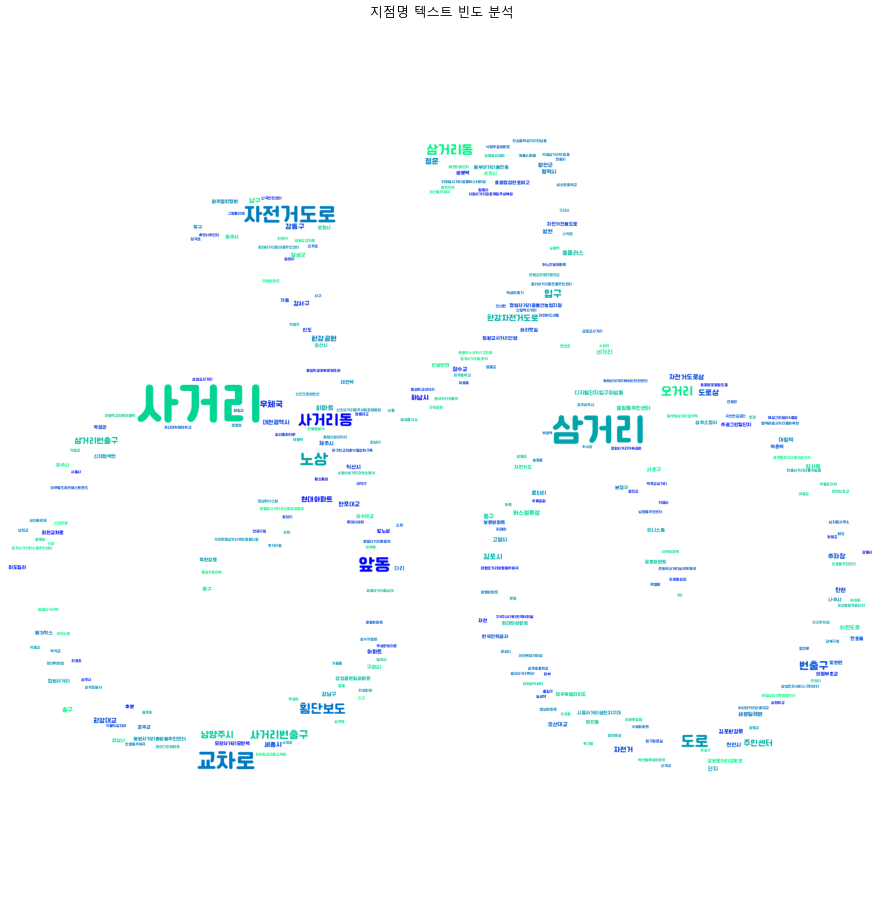

In [21]:
# 한글 워드크라우드
count_kor = Counter(word_list2)
wordcloud_kor = wordcloud.generate_from_frequencies(count_kor)
fig_kor = plt.figure(figsize = (16, 16))

plt.imshow(wordcloud_kor)
plt.title("지점명 텍스트 빈도 분석", size = 13)
plt.axis('off')
plt.show()

### 2.2 지역별로 건수 그룹핑
   - **사고 현황 데이터를 광역 단위로 묶어서 지역별로 자전거 사고의 현황을 비교해보자.**


<AxesSubplot:xlabel='건수', ylabel='광역'>

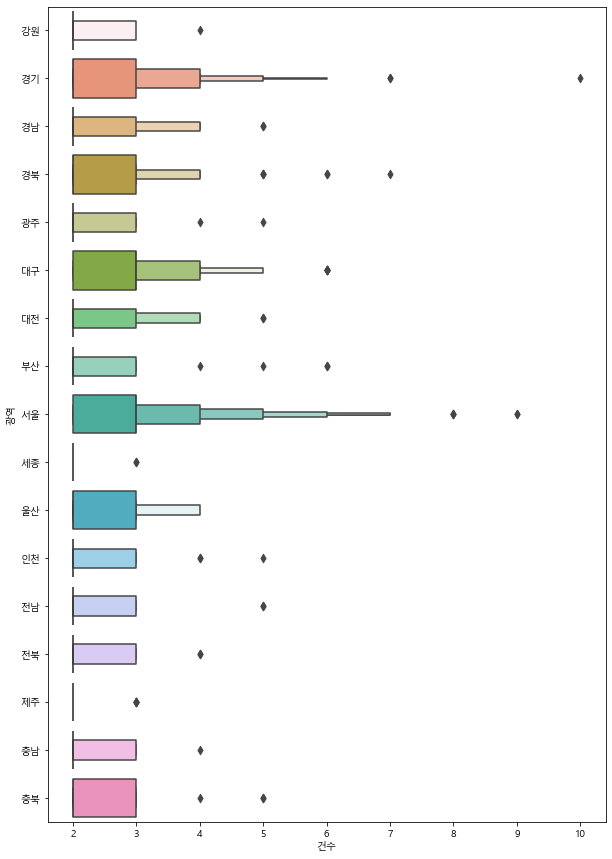

In [22]:
# 각 광역 기준으로 지점별 건수 분포
plt.figure(figsize=(10,15))
sns.boxenplot(data=df, x='건수', y='광역')


In [239]:
# groupby 메소드를 통해 광역 기준으로 묶어준다
# 치사율은 제외하기 위해 마지막 column 제외
df_groupby = df_accident.groupby(['광역']).sum().iloc[:, :-1]

# 지역별 사상자 수 합계를 추가해준다
df_groupby

,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명)
광역,,,,,,,,,
강원,87,1,30,55,1,1,30,57,1
경기,1387,26,551,609,201,26,559,672,222
경남,317,3,141,154,19,3,142,167,22
경북,508,5,234,242,27,5,235,257,29
광주,192,3,56,117,16,3,56,127,16
대구,623,13,250,277,83,13,254,292,88
대전,300,4,136,141,19,4,136,150,24
부산,267,5,98,126,38,5,100,134,40
서울,1983,28,651,1018,286,28,662,1126,345


In [240]:
# 건수 column과 같이 지역별 사상자수 합계 column을 추가해준다
person_sum = df_groupby.iloc[:, 5:].sum(axis=1)
person_sum

광역
강원      89
경기    1479
경남     334
경북     526
광주     202
대구     647
대전     314
부산     279
서울    2161
세종      32
울산     178
인천     163
전남     184
전북     193
제주      50
충남     158
충북     193
dtype: int64

In [241]:
# 사상자수 column index 위치로 추가
df_groupby.insert(5, '사상자수', person_sum)
df_groupby

,건수,사망(건),중상(건),경상(건),부상(건),사상자수,사망(명),중상(명),경상(명),부상(명)
광역,,,,,,,,,,
강원,87,1,30,55,1,89,1,30,57,1
경기,1387,26,551,609,201,1479,26,559,672,222
경남,317,3,141,154,19,334,3,142,167,22
경북,508,5,234,242,27,526,5,235,257,29
광주,192,3,56,117,16,202,3,56,127,16
대구,623,13,250,277,83,647,13,254,292,88
대전,300,4,136,141,19,314,4,136,150,24
부산,267,5,98,126,38,279,5,100,134,40
서울,1983,28,651,1018,286,2161,28,662,1126,345


In [242]:
tmp = df_groupby.reset_index(drop=False)
tmp

,광역,건수,사망(건),중상(건),경상(건),부상(건),사상자수,사망(명),중상(명),경상(명),부상(명)
0,강원,87,1,30,55,1,89,1,30,57,1
1,경기,1387,26,551,609,201,1479,26,559,672,222
2,경남,317,3,141,154,19,334,3,142,167,22
3,경북,508,5,234,242,27,526,5,235,257,29
4,광주,192,3,56,117,16,202,3,56,127,16
5,대구,623,13,250,277,83,647,13,254,292,88
6,대전,300,4,136,141,19,314,4,136,150,24
7,부산,267,5,98,126,38,279,5,100,134,40
8,서울,1983,28,651,1018,286,2161,28,662,1126,345
9,세종,30,1,19,8,2,32,1,20,9,2


In [38]:
# 그래프 그릴 때, 전역 파라미터 설정
parameters = {'axes.titlesize': 25, 
              'axes.labelsize': 18,
              'xtick.labelsize': 15,
               'ytick.labelsize' : 15}
plt.rcParams.update(parameters)

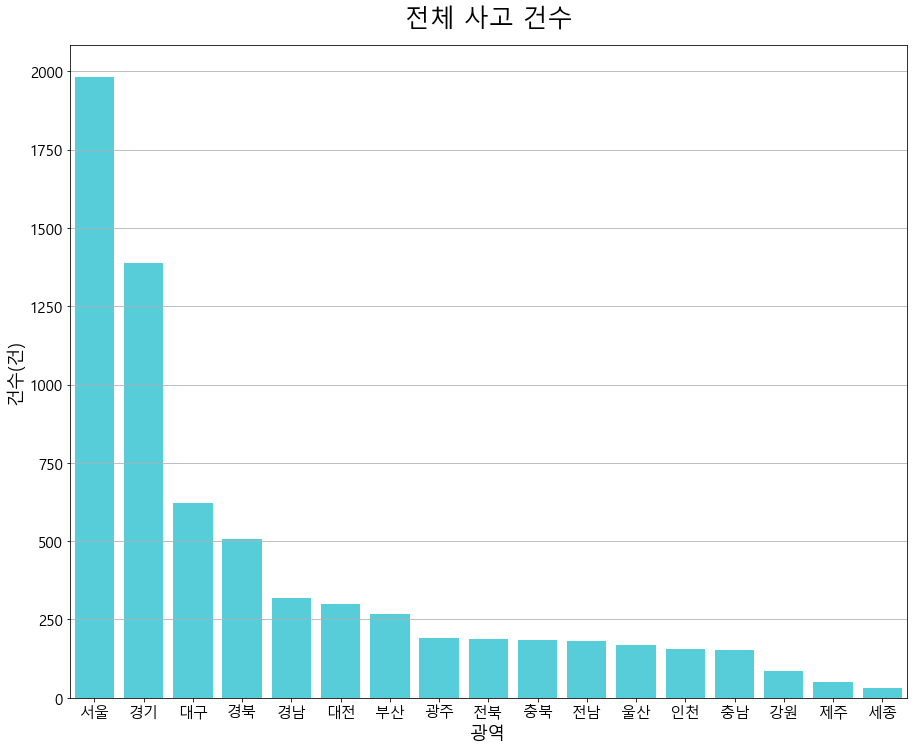

In [39]:
plt.figure(figsize=(15, 12))

# 색 설정
color = ['#40DFEF' for _ in range(len(tmp))]
sns.barplot(data = tmp,
            x='광역', y = '건수',
            order = tmp.sort_values('건수', ascending=False).광역, palette=color)

plt.xlabel('광역')
plt.ylabel('건수(건)')
plt.grid(axis='y')
plt.title('전체 사고 건수', pad=20)
plt.show()

In [40]:
tmp['인구'] = [1542840,
                   13427014, 
                   3340216,
                   2639422,
                1450062,
                2418346,
                1463882,
                3391946,
                9668465,
                355831,
                1136017,
                2942828,
                1851549,
                1804104,
                674635,
                2121029,
                1600837
                   ]
tmp['사고건수(10만)'] = tmp['건수'] / tmp['인구'] * 100000
tmp

,광역,건수,사망(건),중상(건),경상(건),부상(건),사상자수,사망(명),중상(명),경상(명),부상(명),인구,사고건수(10만)
0,강원,87,1,30,55,1,89,1,30,57,1,1542840,5.638952
1,경기,1387,26,551,609,201,1479,26,559,672,222,13427014,10.329921
2,경남,317,3,141,154,19,334,3,142,167,22,3340216,9.490404
3,경북,508,5,234,242,27,526,5,235,257,29,2639422,19.246638
4,광주,192,3,56,117,16,202,3,56,127,16,1450062,13.240813
5,대구,623,13,250,277,83,647,13,254,292,88,2418346,25.761409
6,대전,300,4,136,141,19,314,4,136,150,24,1463882,20.493455
7,부산,267,5,98,126,38,279,5,100,134,40,3391946,7.871588
8,서울,1983,28,651,1018,286,2161,28,662,1126,345,9668465,20.509978
9,세종,30,1,19,8,2,32,1,20,9,2,355831,8.430969


In [45]:
pop_index = tmp[['광역', '사고건수(10만)']].sort_values(by='사고건수(10만)', ascending=False)['광역']

#### 대구의 인구대비 사고건수 1위

-관련뉴스 : http://news.imaeil.com/page/view/2021101218140671568

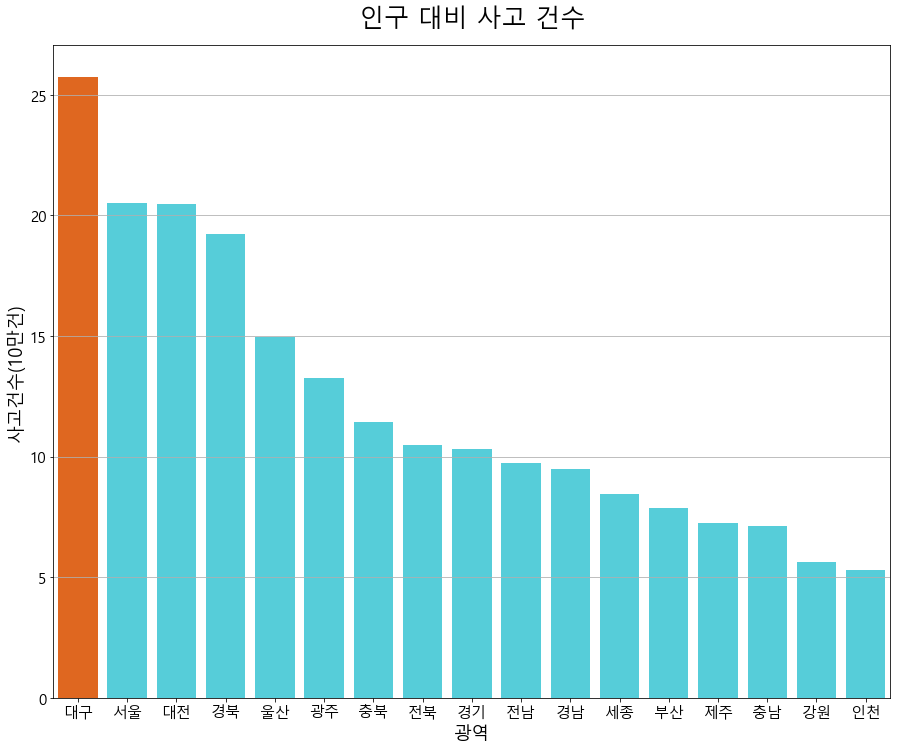

In [48]:
tmp.sort_values('사고건수(10만)', ascending=False)

plt.figure(figsize=(15, 12))

# 색 설정
# color = ['#40DFEF' for _ in range(len(tmp))]
color = ['#FF5F00' if gw =='대구' else '#40DFEF' for gw in tmp['광역']]
color = ['#FF5F00'] + ['#40DFEF'] * 16

sns.barplot(data = tmp,
            order = pop_index,
            x='광역', y = '사고건수(10만)',
             palette=color)
plt.ylabel('사고건수(10만건)')
plt.title('인구 대비 사고 건수', pad=20)
plt.grid(axis='y')
plt.show()

In [238]:
# 각 상해 건수가 총 건수에서 차지하는 비율
df_groupby_count = df_groupby.iloc[:, 1:5] .div(list(df_groupby['건수']), axis=0)
df_groupby_count

,사망(건),중상(건),경상(건),부상(건)
광역,,,,
강원,0.011494,0.344828,0.632184,0.011494
경기,0.018745,0.397260,0.439077,0.144917
경남,0.009464,0.444795,0.485804,0.059937
경북,0.009843,0.460630,0.476378,0.053150
광주,0.015625,0.291667,0.609375,0.083333
대구,0.020867,0.401284,0.444623,0.133226
대전,0.013333,0.453333,0.470000,0.063333
부산,0.018727,0.367041,0.471910,0.142322
서울,0.014120,0.328290,0.513364,0.144226


In [50]:
# 보기 쉽게 percent 수치로 바꾸어보자
df_groupby_count_percent = round(df_groupby_count * 100, 1)
df_groupby_count_percent

,사망(건),중상(건),경상(건),부상(건)
광역,,,,
강원,1.1,34.5,63.2,1.1
경기,1.9,39.7,43.9,14.5
경남,0.9,44.5,48.6,6.0
경북,1.0,46.1,47.6,5.3
광주,1.6,29.2,60.9,8.3
대구,2.1,40.1,44.5,13.3
대전,1.3,45.3,47.0,6.3
부산,1.9,36.7,47.2,14.2
서울,1.4,32.8,51.3,14.4


In [51]:
df_groupby_count_percent.describe()

,사망(건),중상(건),경상(건),부상(건)
count,17.000000,17.000000,17.000000,17.000000
mean,1.841176,40.735294,48.100000,9.300000
std,1.011842,7.818163,7.800881,4.586802
min,0.000000,29.200000,26.700000,1.100000
25%,1.100000,36.500000,44.500000,6.000000
50%,1.800000,40.100000,47.600000,8.300000
75%,2.700000,44.500000,51.300000,13.300000
max,3.300000,63.300000,63.200000,18.400000


####  지역별 사고 건수 시각화
   - **위의 데이터를 히트맵으로 시각화하여 지역별 건수를 한눈에 비교해보자.**
   - 세종시의 사망, 중상건수 비율이 두드러지게 높은 것을 확인할 수 있다 (http://www.ccherald.kr/news/articleView.html?idxno=13680)

In [52]:
tmp = df_groupby_count_percent.reset_index()
tmp.rename(columns = {"사망(건)" : "사망", "중상(건)" : "중상", "경상(건)": "경상", "부상(건)" : "부상"}, inplace=True)

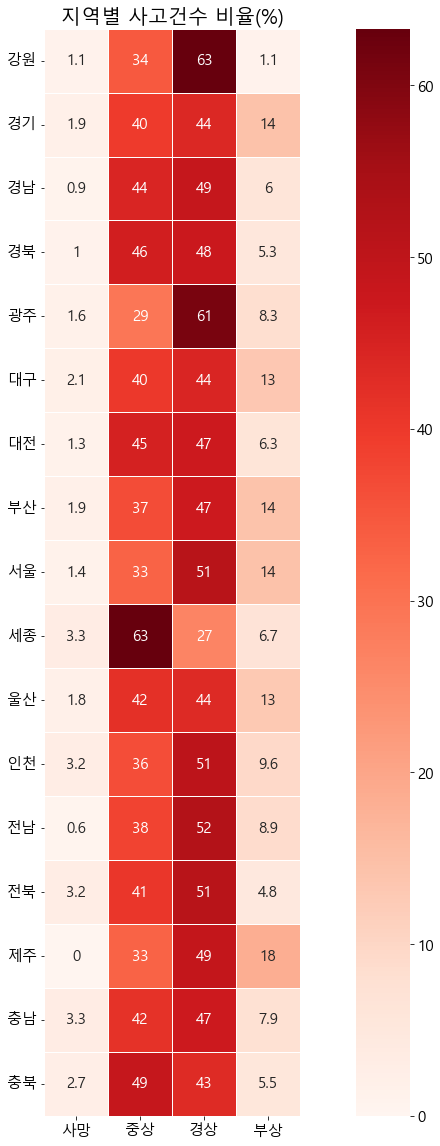

In [53]:
# heatmap으로 한 눈에 표현
# 다음은 100건 중 몇 건이 일어나는지 나타내는 것임
plt.figure(figsize=(20, 20))
sns.heatmap(data=tmp.iloc[:, 1:] ,cmap="Reds",square=True, yticklabels=tmp['광역'], 
            annot=True,
            linewidth=.5, annot_kws={"size": 15}) # box간 간격, 글자 크기

plt.title('지역별 사고건수 비율(%)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15, rotation=0)
plt.show()

###  2.3 세부정보 데이터 보기

In [59]:
# 세부정보 위주로 탐색해보자
df_detail = df.iloc[:, :32]
df_detail.head()

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,출퇴근,주간,심야,맑음,흐림,비,안개,눈,기상-기타,건수
0,강원,강릉시,강릉시1,0,2,0,0,0,0,0,...,1,1,0,1,0,1,0,0,0,2
1,강원,강릉시,강릉시2,2,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2
2,강원,강릉시,로얄아파트 부근 사거리(동쪽),1,1,0,0,0,0,0,...,0,2,1,3,0,0,0,0,0,3
3,강원,강릉시,성남동 99-9번지,0,2,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2
4,강원,강릉시,스카이베이호텔 부근 도로,0,0,0,0,0,0,0,...,0,2,0,2,0,0,0,0,0,2


In [60]:
df_detail['사업용'].value_counts()

0    2025
1     546
2      66
3       8
4       1
Name: 사업용, dtype: int64

In [61]:
season = df_detail[['봄', '여름', '가을', '겨울']].sum().sort_values(ascending=False)
season

여름    2076
가을    1904
봄     1749
겨울    1043
dtype: int64

In [63]:
# 그래프 그릴 때, 전역 파라미터 설정
parameters = {'axes.titlesize': 25, 
              'axes.labelsize': 18,
              'xtick.labelsize': 15,
               'ytick.labelsize' : 15}
plt.rcParams.update(parameters)

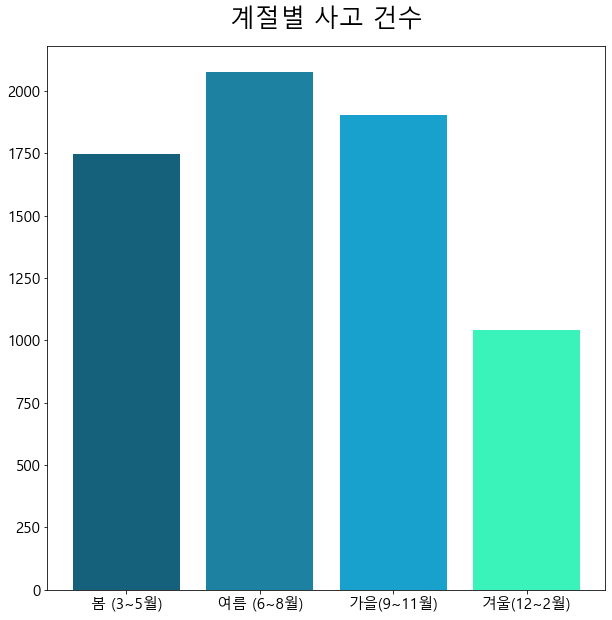

In [67]:
# 계절별 분석
season = df_detail[['봄', '여름', '가을', '겨울']].sum()

fig, ax = plt.subplots(figsize=(10,10))

plt.bar(x=season.index, height=season,
        color = ["#15607a","#1d81a2",  "#18a1cd", "#39f3bb"],
       )
plt.title('계절별 사고 건수', pad=20)
ax.set_xticklabels(['봄 (3~5월)', '여름 (6~8월)', '가을(9~11월)', '겨울(12~2월)'])
plt.show()


In [81]:
illegal = df_detail[['중앙선침범', '신호위반', '안전거리미확보',
       '불법유턴', '과속', '안전운전불이행', '교차로위반',
        '보행자보호위반', '차로위반', '직진우회전방해', '법규-기타']].sum().sort_values(ascending=False)
illegal

안전운전불이행    4336
신호위반        922
교차로위반       430
중앙선침범       290
법규-기타       287
불법유턴        169
직진우회전방해     152
안전거리미확보     119
보행자보호위반      31
차로위반         20
과속           10
dtype: int64

- 안전운전불이행이 전체 사고건수 원인의 64%를 차지

In [82]:
illegal/illegal.sum() * 100

안전운전불이행    64.085132
신호위반       13.626958
교차로위반       6.355306
중앙선침범       4.286137
법규-기타       4.241797
불법유턴        2.497783
직진우회전방해     2.246527
안전거리미확보     1.758794
보행자보호위반     0.458173
차로위반        0.295596
과속          0.147798
dtype: float64

In [83]:
# pie chart로 뚜렷하게 나타내기 위해 top4 이외의 항목은 기타 처리
illegal_etc = illegal[4:].sum()

In [84]:
illegal = illegal.drop(labels=illegal.index[4:])
illegal['기타'] = illegal_etc

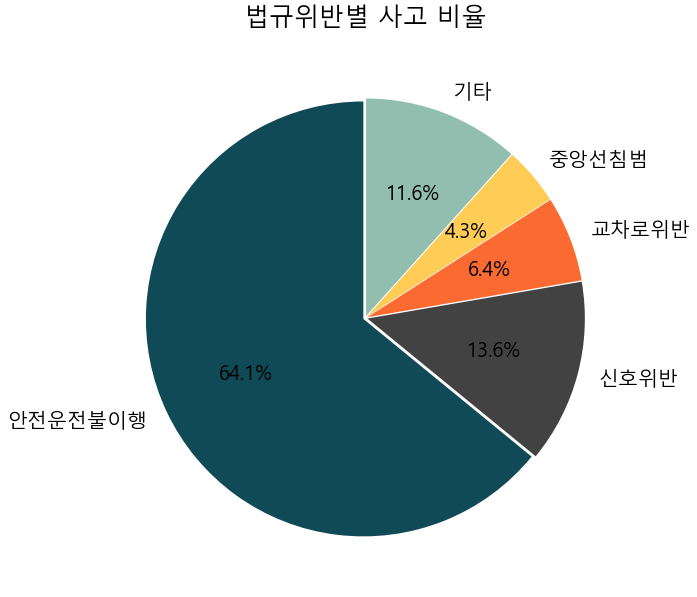

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

plt.pie(illegal,
        autopct='%.1f%%', 
        labels = illegal.index,
        #12시 방향으로 함
        startangle =90,
        # chart 사이 간격
        explode = (0.01, 0.01, 0.01, 0.01, 0.01),
        textprops={'fontsize': 20},
       colors = ["#104a56", "#424242", "#fb6a31", "#ffcc56", "#92beaf",  ])
plt.title('법규위반별 사고 비율', pad=20)
plt.show()

- 안전운전불이행이 전체 사고건수 원인의 64%를 차지

In [89]:
time = df_detail[['새벽', '출퇴근', '주간', '심야']].sum().sort_values(ascending=False)
time

주간     3804
출퇴근    1917
심야      730
새벽      321
dtype: int64

In [256]:
# 시간대 기준 단위 시간 별 사고건수
print(f"주간 : {time[0] / 11}건")
print(f"출퇴근 : {time[1] / 3}건")
print(f"심야 : {time[2] / 8}건")
print(f"새벽 : {time[3] / 2}건")

주간 : 345.8181818181818건
출퇴근 : 639.0건
심야 : 91.25건
새벽 : 160.5건


In [ ]:
time

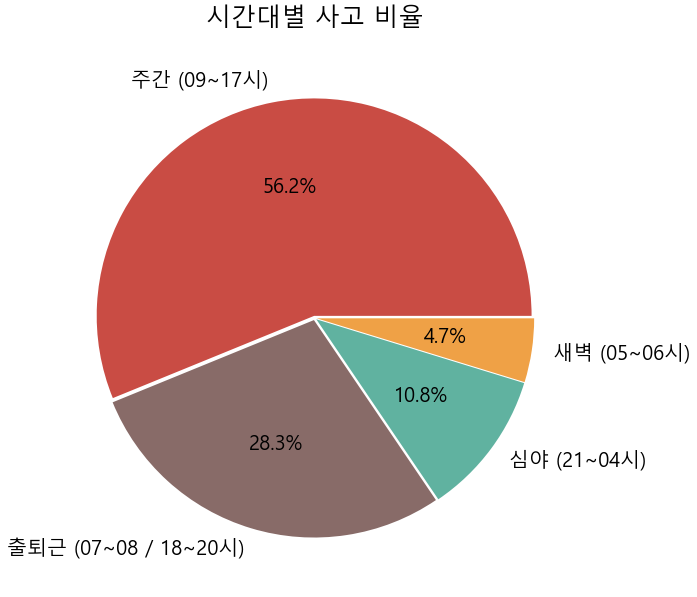

In [93]:
fig, ax = plt.subplots(figsize=(10,10))

plt.pie(time,
        autopct='%.1f%%', 
        labels = ['주간 (09~17시)', '출퇴근 (07~08 / 18~20시)', '심야 (21~04시)', '새벽 (05~06시)'],
        explode = (0.01, 0.01, 0.01, 0.01),
        textprops={'fontsize': 20},
       colors = ["#c94c44","#886b68",  "#60b2a0", "#efa146"])
plt.title('시간대별 사고 비율', pad=20)
plt.show()

In [94]:
weather = df_detail[['맑음', '흐림', '비', '안개', '눈', '기상-기타']].sum().sort_values(ascending=False)
weather

맑음       6390
비         175
흐림        174
기상-기타      32
눈           1
안개          0
dtype: int64

In [95]:
tmp = pd.DataFrame({"맑음" : [6390], "비" : [175], "흐림":[174], "기타": [33]})

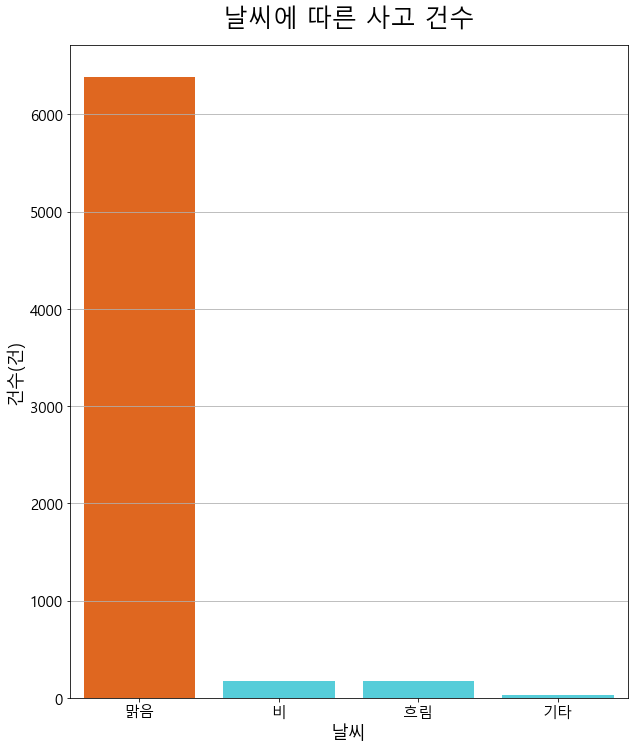

In [96]:
# 여기서 기타는 눈, 안개, 그리고 원래 기타항목만 포함
plt.figure(figsize=(10, 12))

# 색 설정
color =  ['#FF5F00'] + ['#40DFEF' for _ in range(3)]
sns.barplot(data = tmp,
            palette=color)

plt.xlabel('날씨')
plt.ylabel('건수(건)')
plt.grid(axis='y')
plt.title('날씨에 따른 사고 건수', pad=20)
plt.show()

## 3. 데이터 분석


### 3.1  자전거도로 관련 추가분석

#### `01. 자전거도로와 비자전거도로 비교`

In [144]:
# 자전거도로 df
bicycle_filter_1 = df['지점명'].str.contains('자전거 도로', na=False) # 지점명 내의 글자에 자전거 도로가 있는 것들에 대한 필터
df_1 = df[bicycle_filter_1] # 필터 적용

bicycle_filter_2 = df['지점명'].str.contains('자전거도로', na=False) # 지점명 내의 글자에 자전거 도로가 있는 것들에 대한 필터
df_2 = df[bicycle_filter_2] # 필터 적용

bicycle = pd.concat([df_1, df_2]).drop_duplicates()  # 중복 제거하면서자전거도로, 자전거 도로 합치기
bicycle.head()

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
70,경기,고양시,창릉교 밑 자전거 도로,0,0,0,0,0,0,0,...,2,0,2,0,0,0,2,2,0,0.0
75,경기,고양시,행주내동 59근방 자전거 도로,0,0,0,0,0,0,0,...,2,0,1,0,1,0,1,0,1,0.0
166,경기,남양주시,경기도 남양주시 와부읍 팔당리 401 자전거 도로,0,0,0,0,0,0,0,...,5,0,3,2,0,0,4,5,1,0.0
248,경기,성남시,이매1지하보도 밑 자전거 도로,0,0,0,0,0,0,0,...,3,0,1,2,0,0,1,3,1,0.0
369,경기,안양시,박석교 옆 안양천변 자전거 도로 박석교 옆 안양천변 자전거 도,0,0,0,0,0,1,0,...,3,0,1,2,0,0,1,2,0,0.0


In [145]:
del_idx = []
for idx_1,location in enumerate(df['지점명']):
    for idx,location_2 in enumerate(bicycle['지점명']):
        if location==location_2:
            del_idx.append(idx_1)

not_bicycle = df.drop(del_idx)

In [146]:
is_duplicated = pd.concat([bicycle,not_bicycle])
is_duplicated.duplicated().sum() #하나도 안겹침

0

In [147]:
bicycle.describe()

,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,과속,안전운전불이행,교차로위반,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
count,87.000000,87.000000,87.0,87.000000,87.000000,87.000000,87.0,87.0,87.000000,87.000000,...,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,0.022989,0.103448,0.0,0.045977,0.011494,0.114943,0.0,0.0,2.735632,0.034483,...,3.034483,0.011494,1.252874,1.310345,0.459770,0.011494,1.333333,1.758621,0.804598,0.574713
std,0.150736,0.306309,0.0,0.210649,0.107211,0.355203,0.0,0.0,1.505492,0.183523,...,1.551056,0.107211,0.905004,1.241814,0.695577,0.107211,1.019196,1.725092,1.087338,5.360563
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.000000,0.000000,...,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,3.000000,0.000000,...,3.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,3.000000,1.000000,0.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,2.000000,0.0,0.0,8.000000,1.000000,...,9.000000,1.000000,4.000000,6.000000,3.000000,1.000000,4.000000,8.000000,4.000000,50.000000


In [148]:
# 비자전거도로 df
not_bicycle = df.drop(index=bicycle_road.index)
not_bicycle.head()

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
87,경기,광명시,광명2동주민센터 사거리(북쪽),1,1,0,0,0,0,0,...,2,0,1,1,0,0,1,1,0,0.0
88,경기,광명시,광명경찰서 삼거리,0,1,0,0,0,0,0,...,2,0,0,0,2,0,0,0,2,0.0
89,경기,광명시,광명교 앞 사거리(동단),0,1,0,0,1,0,0,...,3,0,1,2,0,0,1,2,0,0.0
90,경기,광명시,광명동 38-8번지 사거리,2,1,0,1,2,0,0,...,6,0,0,3,3,0,0,3,3,0.0
91,경기,광명시,광명사거리역 부근(서쪽) - 1,0,1,0,0,0,0,0,...,2,0,0,1,1,0,0,1,1,0.0


In [149]:
not_bicycle.describe()

,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,과속,안전운전불이행,교차로위반,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
count,2559.000000,2559.000000,2559.0,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,...,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000
mean,0.267292,0.992184,0.0,0.110199,0.351309,0.044549,0.065651,0.003908,1.639703,0.162954,...,2.567018,0.043376,0.988667,1.236811,0.298163,0.043376,1.001954,1.340367,0.338413,1.884572
std,0.519808,0.925666,0.0,0.341846,0.633065,0.210106,0.271798,0.062402,1.085084,0.406672,...,0.951164,0.205652,0.819206,0.975961,0.553439,0.205652,0.840015,1.070710,0.626161,9.169455
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,3.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
max,4.000000,7.000000,0.0,3.000000,4.000000,2.000000,3.000000,1.000000,8.000000,2.000000,...,10.000000,2.000000,5.000000,6.000000,4.000000,2.000000,5.000000,8.000000,5.000000,100.000000


In [150]:
print(f"전체 건수 대비 자전거도로 사고 건수 비율 : {264/6772 * 100:.2f}%")

전체 건수 대비 자전거도로 사고 건수 비율 : 3.90%


### t-test 분석
- 유의수준을 0.05로 두자

## `요약`
|컬럼명|t-test 결과|
|------|---|
|사망(건)|차이 o|
|중상(건)|차이 o|
|부상(건)|차이 x|
|경상(건)|차이 o|

사망 t-test

In [151]:
not_bicycle_death = not_bicycle['사망(건)']
bicycle_death = bicycle['사망(건)']

In [152]:
stats.ttest_ind(not_bicycle_death, bicycle_death, equal_var = False)

Ttest_indResult(statistic=2.614997940295182, pvalue=0.010188279035205701)

In [153]:
print(f"자전거도로에서의 사망 건수의 평균은{bicycle.describe()['사망(건)']['mean']:.3}\n"
f"비자전거도로에서의 사망 건수의 평균은 {not_bicycle.describe()['사망(건)']['mean']:.3}")

자전거도로에서의 사망 건수의 평균은0.0115
비자전거도로에서의 사망 건수의 평균은 0.0434


`결과` : 0.05보다 작으므로 귀무가설을 기각 => 통계적으로 유의미한 차이가 있다.

중상 t-test

In [154]:
not_bicycle_injury = not_bicycle['중상(건)']
bicycle_injury = bicycle['중상(건)']

In [155]:
stats.ttest_ind(not_bicycle_injury,bicycle_injury, equal_var = False)

Ttest_indResult(statistic=-2.685873865856118, pvalue=0.008600388263232799)

In [156]:
print(f"자전거도로에서의 부상 건수의 평균은{bicycle.describe()['중상(건)']['mean']:.3}\n"
f"비자전거도로에서의 부상 건수의 평균은 {not_bicycle.describe()['중상(건)']['mean']:.3}")

자전거도로에서의 부상 건수의 평균은1.25
비자전거도로에서의 부상 건수의 평균은 0.989


`결과` : 0.05보다 작으므로 귀무가설을 기각 =>  통계적으로 유의미한 차이가 있다.

경상 t-test

In [157]:
not_bicycle_injury_2= not_bicycle['경상(건)']
bicycle_injury_2 = bicycle['경상(건)']

In [158]:
stats.ttest_ind(not_bicycle_injury_2,bicycle_injury_2, equal_var = False)

Ttest_indResult(statistic=-0.5466082743444802, pvalue=0.5860058202385952)

In [159]:
print(f"자전거도로에서의 경상 건수의 평균은{bicycle.describe()['경상(건)']['mean']:.3}\n"
f"비자전거도로에서의 경상 건수의 평균은 {not_bicycle.describe()['경상(건)']['mean']:.3}")

자전거도로에서의 경상 건수의 평균은1.31
비자전거도로에서의 경상 건수의 평균은 1.24


`결과` : 0.05보다 크므로 대립가설을 기각 =>  통계적으로 유의미한 차이가 없다.

부상 t-test

In [160]:
not_bicycle_injury_3= not_bicycle['부상(건)']
bicycle_injury_3 = bicycle['부상(건)']

In [161]:
stats.ttest_ind(not_bicycle_injury_3,bicycle_injury_3, equal_var = False)

Ttest_indResult(statistic=-2.14412315034639, pvalue=0.03472643537630506)

In [162]:
print(f"자전거도로에서의 부상 건수의 평균은{bicycle.describe()['부상(건)']['mean']:.3}\n"
f"비자전거도로에서의 부상 건수의 평균은 {not_bicycle.describe()['부상(건)']['mean']:.3}")

자전거도로에서의 부상 건수의 평균은0.46
비자전거도로에서의 부상 건수의 평균은 0.298


`결과` : 0.05보다 작으므로 귀무가설을 기각 => 통계적으로 유의미한 차이가 있다.

- t-test로 평균 차이 확인완료. 정확한 차이 확인을 위해 기술통계량 비교 진행


In [169]:
#자전거도로 사고 건 기술통계량
bicycle_road.iloc[:, -10:-5].describe()

,건수,사망(건),중상(건),경상(건),부상(건)
count,87.000000,87.000000,87.000000,87.000000,87.000000
mean,3.034483,0.011494,1.252874,1.310345,0.459770
std,1.551056,0.107211,0.905004,1.241814,0.695577
min,2.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,1.000000,0.000000
75%,3.000000,0.000000,2.000000,2.000000,1.000000
max,9.000000,1.000000,4.000000,6.000000,3.000000


In [170]:
# 비자전거도로 사고 건 기술통계량
not_bicycle_road.iloc[:, -10:-5].describe()

,건수,사망(건),중상(건),경상(건),부상(건)
count,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000
mean,2.567018,0.043376,0.988667,1.236811,0.298163
std,0.951164,0.205652,0.819206,0.975961,0.553439
min,2.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,0.000000,1.000000,1.000000,0.000000
75%,3.000000,0.000000,1.000000,2.000000,1.000000
max,10.000000,2.000000,5.000000,6.000000,4.000000


In [171]:
death_in_bicycle_road = bicycle_road.loc[(bicycle_road['사망(건)'] != 0) | (bicycle_road['사망(명)'] != 0), '사망(명)']
death_in_bicycle_road

74    1
Name: 사망(명), dtype: int64

In [172]:
bicycle_road['지점명'][74]

'한강 자전거도로 뚝섬공원 2-54앞'

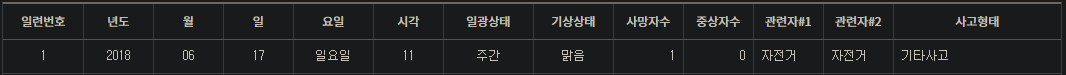

In [173]:
from IPython.display import Image
Image("pic/한강 자전거도로 뚝섬공원 2-54앞.png")

=> 자전거도로 내 사망사고는 예상 외로 자동차와 자전거 사고가 아닌 자전거와 자전거 사고였다.

##### 자전거도로 내 사고는 뭉쳐 있는 경우가 많다.
- 자전거도로 사고 대부분 서울 내 강 근처에서 발생하며, 좁거나 복잡한 도로에서 누적되어서 발생함을 알 수 있다.

In [174]:
bicycle_road.sort_values(by='건수', ascending=False)['기초'][:10]

83    영등포구
82    영등포구
18    영등포구
15     송파구
78    영등포구
58     동작구
16     송파구
2     남양주시
71     서초구
44     하남시
Name: 기초, dtype: object

In [175]:
# img_1 = Image("영등포구 양화한강공원.png", width=500, height=500)
import matplotlib.image as img
img_1 = img.imread('pic/영등포구 양화한강공원.png')
img_2 = img.imread('pic/영등포구 양화한강공원2.png')
img_3 = img.imread('pic/영등포구 양화한강공원 부근 자전거도로.png')
img_4 = img.imread('pic/송파 자전거도로.png')
img_5 = img.imread('pic/문래 안양천 자전거도로.png')
img_6 = img.imread('pic/광진구 뚝섬 한강공원.png')

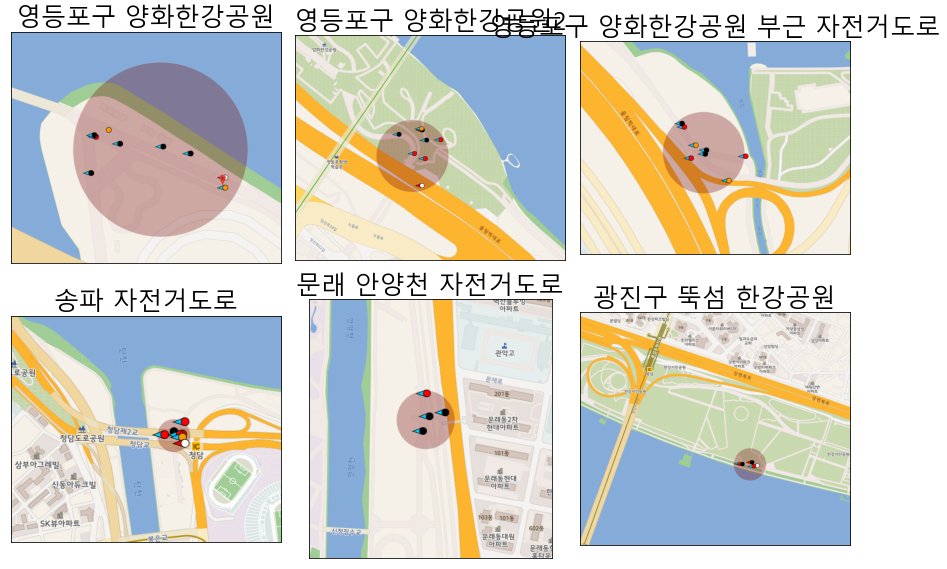

In [176]:
fig = plt.figure(figsize=(12,8))
rows = 2; cols = 3

ax1 = fig.add_subplot(rows, cols, 1)
ax1.set_title('영등포구 양화한강공원')
# ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(img_1)

ax2 = fig.add_subplot(rows, cols, 2)
ax2.set_title('영등포구 양화한강공원2')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(img_2)

ax3 = fig.add_subplot(rows, cols, 3)
ax3.set_title('영등포구 양화한강공원 부근 자전거도로')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.imshow(img_3)

ax4 = fig.add_subplot(rows, cols, 4)
ax4.set_title('송파 자전거도로')
ax4.set_xticks([])
ax4.set_yticks([])
ax4.imshow(img_4)

ax5 = fig.add_subplot(rows, cols, 5)
ax5.set_title('문래 안양천 자전거도로')
ax5.set_xticks([])
ax5.set_yticks([])
ax5.imshow(img_5)

ax6 = fig.add_subplot(rows, cols, 6)
ax6.set_title('광진구 뚝섬 한강공원')
ax6.set_xticks([])
ax6.set_yticks([])
ax6.imshow(img_6)

fig.tight_layout()
plt.show()

In [177]:
bicycle_filter_1 = df['광역'].str.contains('서울',na=False) #서울 거르기
seoul = df[bicycle_filter_1]

In [178]:
bicycle_filter_1 = seoul['지점명'].str.contains('한강',na=False)
seoul_h = seoul[bicycle_filter_1]
seoul_h.head()

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
1479,서울,강남구,미니스톱 한강잠원2호점 앞 자전거도로,0,0,0,0,0,0,0,...,2,0,2,0,0,0,2,0,0,0.0
1489,서울,강남구,서울특별시 강남구 압구정로11길 37-53 한강잠원공원 자전거도로,0,0,0,0,0,0,0,...,2,0,2,0,0,0,2,0,0,0.0
1490,서울,강남구,서울특별시 강남구 청담동 341-1 한강 자전거도로,0,0,0,0,0,0,0,...,3,0,0,3,0,0,0,4,0,0.0
1516,서울,강동구,서울특별시 강동구 암사동 613-11 한강공원 자전거도로상,0,0,0,0,0,0,0,...,3,0,1,0,2,0,1,0,3,0.0
1517,서울,강동구,서울특별시 강동구 암사동 624-3 광나루한강공원 축구장 부근 자,0,0,0,0,0,0,0,...,4,0,1,2,1,0,1,2,2,0.0


In [179]:
s_s_h = pd.concat([seoul,seoul_h])
seoul_not_h = s_s_h.drop_duplicates(s_s_h.columns, keep = False)

In [180]:
seoul_not_h.shape #한강이 아닌 서울

(641, 41)

In [181]:
seoul.shape

(682, 41)

In [182]:
seoul_h.shape

(41, 41)

In [183]:
seoul_h.describe()

,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,과속,안전운전불이행,교차로위반,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
count,41.000000,41.000000,41.0,41.000000,41.000000,41.000000,41.000000,41.0,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.00000,41.000000
mean,0.146341,0.195122,0.0,0.048780,0.073171,0.121951,0.024390,0.0,3.146341,0.024390,...,3.536585,0.024390,1.292683,1.609756,0.609756,0.024390,1.341463,2.243902,1.00000,1.219512
std,0.527303,0.459321,0.0,0.218085,0.345705,0.399695,0.156174,0.0,1.969276,0.156174,...,1.976076,0.156174,0.980915,1.429651,0.862498,0.156174,1.063244,1.946542,1.30384,7.808688
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,0.000000,...,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.00000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,0.000000,...,4.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,3.000000,2.00000,0.000000
max,3.000000,2.000000,0.0,1.000000,2.000000,2.000000,1.000000,0.0,8.000000,1.000000,...,9.000000,1.000000,4.000000,5.000000,3.000000,1.000000,4.000000,8.000000,5.00000,50.000000


In [100]:
seoul_not_h.describe()

,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,과속,안전운전불이행,교차로위반,...,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%)
count,641.000000,641.000000,641.0,641.000000,641.000000,641.000000,641.000000,641.0,641.000000,641.000000,...,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000
mean,0.397816,0.585023,0.0,0.143526,0.435257,0.074883,0.081123,0.0,1.744150,0.098284,...,2.867395,0.042122,0.932917,1.485179,0.407176,0.042122,0.946958,1.613105,0.474259,1.816358
std,0.621939,0.794135,0.0,0.392897,0.677268,0.269275,0.300473,0.0,1.226046,0.323091,...,1.139989,0.201024,0.806338,1.108285,0.615842,0.201024,0.821771,1.184569,0.720053,8.890771
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,...,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,2.000000,0.000000,...,3.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
max,3.000000,5.000000,0.0,2.000000,4.000000,2.000000,2.000000,0.0,7.000000,2.000000,...,9.000000,1.000000,4.000000,6.000000,4.000000,1.000000,4.000000,6.000000,4.000000,50.000000


서울 - 한강에서의 사망 평균 명수 0.02<br>
서울 - 한강이 아닌 경우 사망 평균 명수 0.04

서울 - 한강에서의 중상 평균 명수 1.34<br>
서울 - 한강이 아닌 경우 중상 평균 명수 0.95

서울 - 한강에서의 경상 평균 명수 2.24<br>
서울 - 한강이 아닌 경우 경상 평균 명수 1.612

서울 - 한강에서의 부상 평균 명수 1.00<br>
서울 - 한강이 아닌 경우 부상 평균 명수 0.468

사망의 경우에는 한강이 아닌 경우가 낮지만, 중상과 경상, 부상의 경우에는 한강인 경우가 높다!
=> 자전거 도로와 비자전거 도로 비교와 비슷한 양상

In [101]:
bicycle_road_accident_reason = {}
accident_reasons = ['중앙선침범', '신호위반', '안전거리미확보',
       '불법유턴', '과속', '안전운전불이행', '교차로위반', '보행자보호위반', '차로위반', '직진우회전방해', '법규-기타']

In [102]:
for accident_reason in accident_reasons:
    cnt=0
    for idx,reason_cnt in enumerate(seoul_h[f"{accident_reason}"]):
        cnt += reason_cnt
    bicycle_road_accident_reason[f"{accident_reason}"]=cnt

In [103]:
bicycle_road_accident_reason

{'중앙선침범': 2,
 '신호위반': 3,
 '안전거리미확보': 5,
 '불법유턴': 1,
 '과속': 0,
 '안전운전불이행': 129,
 '교차로위반': 1,
 '보행자보호위반': 3,
 '차로위반': 0,
 '직진우회전방해': 0,
 '법규-기타': 1}

한강에서의 사고의 주요 원인은 안전운전불이행

### 3.2 교차로, 사거리등 지점이 다른 구간에 비해 얼마나 심각한지

In [184]:
intersect_filter = df['지점명'].str.contains('교차로',na=False)
intersect= df[intersect_filter]

In [185]:
del_idx = []
for idx_1,location in enumerate(df['지점명']):
    for idx,location_2 in enumerate(intersect['지점명']):
        if location==location_2:
            del_idx.append(idx_1)

not_intersect = df.drop(del_idx)

In [186]:
is_duplicated = pd.concat([intersect,not_intersect])
is_duplicated.duplicated().sum() #하나도 안겹침

0

### t-test

In [187]:
from scipy import stats

## `요약`
|컬럼명|t-test 결과|
|------|---|
|사망(건)|차이 o|
|중상(건)|차이 x|
|부상(건)|차이 x|
|경상(건)|차이 x|

사망 t-test

In [188]:
not_intersect_death = not_intersect['사망(건)']
intersect_death = intersect['사망(건)']

In [189]:
stats.ttest_ind(not_intersect_death, intersect_death, equal_var = False)

Ttest_indResult(statistic=1.478937496043259, pvalue=0.1404528837574727)

In [200]:
print(f"교차로에서의 사망 건수의 평균은{intersect.describe()['사망(건)']['mean']:.3}\n"
f"비교차로에서의 사망 건수의 평균은 {not_intersect.describe()['사망(건)']['mean']:.3}")

교차로에서의 사망 건수의 평균은0.0262
비교차로에서의 사망 건수의 평균은 0.0444


`결과` : 0.05보다 작으므로 귀무가설을 기각 => 통계적으로 유의미한 차이가 있다.

중상 t-test

In [191]:
not_intersect_injury = not_intersect['중상(건)']
intersect_injury = intersect['중상(건)']

In [192]:
stats.ttest_ind(not_intersect_injury, intersect_injury, equal_var = False)

Ttest_indResult(statistic=-0.2889623566224031, pvalue=0.7728671787747378)

In [202]:
print(f"교차로에서의 중상 건수의 평균은{intersect.describe()['중상(건)']['mean']:.3}\n"
f"비교차로에서의 중상 건수의 평균은 {not_intersect.describe()['중상(건)']['mean']:.3}")

교차로에서의 중상 건수의 평균은1.0
비교차로에서의 중상 건수의 평균은 0.985


`결과` : 0.05보다 크므로 대립가설을 기각 => 통계적으로 유의미한 차이가 없다.

부상 t-test

In [194]:
not_intersect_injury_2 = not_intersect['부상(건)']
intersect_injury_2 = intersect['부상(건)']

In [195]:
stats.ttest_ind(not_intersect_injury_2, intersect_injury_2, equal_var = False)

Ttest_indResult(statistic=1.5676893211165006, pvalue=0.1183472039295084)

In [203]:
print(f"교차로에서의 부상 건수의 평균은{intersect.describe()['부상(건)']['mean']:.3}\n"
f"비교차로에서의 부상 건수의 평균은 {not_intersect.describe()['부상(건)']['mean']:.3}")

교차로에서의 부상 건수의 평균은0.241
비교차로에서의 부상 건수의 평균은 0.301


`결과` : 0.05보다 크므로 대립가설을 기각 => 통계적으로 유의미한 차이가 없다.

경상 t-test

In [197]:
not_intersect_injury_3 = not_intersect['경상(건)']
intersect_injury_3 = intersect['경상(건)']

In [198]:
stats.ttest_ind(not_intersect_injury_3, intersect_injury_3, equal_var = False)

Ttest_indResult(statistic=1.4831846425875106, pvalue=0.13937557878931803)

In [204]:
print(f"교차로에서의 경상 건수의 평균은{intersect.describe()['경상(건)']['mean']:.3}\n"
f"비교차로에서의 경상 건수의 평균은 {not_intersect.describe()['경상(건)']['mean']:.3}")

교차로에서의 경상 건수의 평균은1.15
비교차로에서의 경상 건수의 평균은 1.24


`결과` : 0.05보다 크므로 대립가설을 기각 => 통계적으로 유의미한 차이가 없다.

### 3.3 지역별 분석

#### `01. 지역별 사고 심각도 비교`
히트맵을 통해서 지역별 사망, 중상, 경상, 부상 각 케이스에 대한 심각도는 알 수 있었으나,<br>종합적으로 사고 빈도수와 그 심각도에 대한 비교가 필요하지 않을까?<br>
사망 = 4, 중상 = 3, 경상 = 2, 부상 = 1로 사고의 심각한 척도를 정하고<br>
-> 각 케이스별 건수 * 위의 점수를 더하여 종합적인 심각도를 나타내는 열 추가

In [229]:
#건수 기준
tmp = df
tmp['심각도(건)'] = tmp['사망(건)'] * 4 + tmp['중상(건)'] * 3 + tmp['경상(건)'] * 2 + tmp['부상(건)'] * 1
tmp

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차
0,강원,강릉시,강릉시1,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0.000000,6,6,0
1,강원,강릉시,강릉시2,2,0,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0
2,강원,강릉시,로얄아파트 부근 사거리(동쪽),1,1,0,0,0,0,0,...,1,1,0,1,1,1,0.000000,6,6,0
3,강원,강릉시,성남동 99-9번지,0,2,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0
4,강원,강릉시,스카이베이호텔 부근 도로,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0.000000,6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,충북,충주시,충주시립도서관 앞 사거리(동쪽),0,1,0,0,0,1,0,...,3,0,0,1,3,1,0.000000,9,10,1
2642,충북,충주시,충주종합운동장(남서),0,2,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0
2643,충북,충주시,칠금동 327-2번지,0,2,0,0,0,0,0,...,2,0,1,0,2,0,33.333333,8,8,0
2644,충북,충주시,칠금초교 북동 사거리,0,2,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0


In [230]:
tmp_groupby = tmp.groupby(['광역'])['심각도(건)'].mean().sort_values(ascending=False)
tmp_groupby

광역
대구    6.570776
서울    6.432551
경북    5.956522
경기    5.903346
충북    5.833333
세종    5.642857
대전    5.620155
경남    5.602941
울산    5.486111
충남    5.338235
인천    5.275362
전북    5.264368
전남    5.253165
강원    5.125000
부산    5.118644
광주    4.886364
제주    4.772727
Name: 심각도(건), dtype: float64

In [231]:
#명수 기준
tmp['심각도(명)'] = tmp['사망(명)'] * 4 + tmp['중상(명)'] * 3 + tmp['경상(명)'] * 2 + tmp['부상(명)'] * 1
tmp

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차
0,강원,강릉시,강릉시1,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0.000000,6,6,0
1,강원,강릉시,강릉시2,2,0,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0
2,강원,강릉시,로얄아파트 부근 사거리(동쪽),1,1,0,0,0,0,0,...,1,1,0,1,1,1,0.000000,6,6,0
3,강원,강릉시,성남동 99-9번지,0,2,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0
4,강원,강릉시,스카이베이호텔 부근 도로,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0.000000,6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,충북,충주시,충주시립도서관 앞 사거리(동쪽),0,1,0,0,0,1,0,...,3,0,0,1,3,1,0.000000,9,10,1
2642,충북,충주시,충주종합운동장(남서),0,2,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0
2643,충북,충주시,칠금동 327-2번지,0,2,0,0,0,0,0,...,2,0,1,0,2,0,33.333333,8,8,0
2644,충북,충주시,칠금초교 북동 사거리,0,2,0,0,0,0,0,...,1,0,0,1,1,0,0.000000,5,5,0


In [232]:
# 건수와 명수의 차를 나타내는 열 추가
tmp['심각도_차'] = tmp['심각도(명)'] - tmp['심각도(건)']
tmp.head()

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차
0,강원,강릉시,강릉시1,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0.0,6,6,0
1,강원,강릉시,강릉시2,2,0,0,0,0,0,0,...,1,0,0,1,1,0,0.0,5,5,0
2,강원,강릉시,로얄아파트 부근 사거리(동쪽),1,1,0,0,0,0,0,...,1,1,0,1,1,1,0.0,6,6,0
3,강원,강릉시,성남동 99-9번지,0,2,0,0,0,0,0,...,1,0,0,1,1,0,0.0,5,5,0
4,강원,강릉시,스카이베이호텔 부근 도로,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0.0,6,6,0


In [233]:
tmp.nlargest(10, ['심각도_차']) #명수와 건수의 차이가 많은 top 10

,광역,기초,지점명,사업용,비사업용,기타,중앙선침범,신호위반,안전거리미확보,불법유턴,...,경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차
166,경기,남양주시,경기도 남양주시 와부읍 팔당리 401 자전거 도로,0,0,0,0,0,0,0,...,2,0,0,4,5,1,0.0,13,23,10
1057,대구,달서구,학산남네거리(송일초),2,2,0,0,1,0,0,...,2,0,0,5,4,0,0.0,13,23,10
1353,대전,중구,태평성결교회 앞(오류초 북쪽),0,1,0,0,1,0,1,...,0,1,0,1,3,5,0.0,4,14,10
1454,부산,수영구,수영동 우체국 부근 삼거리(남쪽),1,0,0,0,1,0,0,...,1,0,0,3,3,0,0.0,5,15,10
2054,서울,영등포구,한강자전거도로 자전거도로,0,0,0,0,0,0,0,...,5,0,0,4,8,1,0.0,19,29,10
345,경기,안산시,협성연립삼거리(청소년수련원),0,1,0,1,0,0,0,...,4,0,0,0,8,0,0.0,8,16,8
994,광주,북구,전남대 동쪽 사거리,0,0,0,1,0,0,0,...,1,0,0,1,5,0,0.0,5,13,8
1824,서울,동작구,한강자전거도로 - 1,0,0,0,0,0,0,0,...,0,0,0,3,2,0,0.0,6,13,7
2050,서울,영등포구,한강공원 양화지구 자전거도로,0,0,0,0,0,2,0,...,5,1,0,1,8,2,0.0,14,21,7
2507,충남,공주시,왕릉교 동단 사거리,0,3,0,0,1,0,0,...,1,0,0,3,3,0,0.0,8,15,7


In [234]:
# 크롤링 열은 제거하고 탐색 
tmp = tmp.loc[:, ['광역', '기초','지점명', '건수', '사망(건)', '중상(건)', '경상(건)', '부상(건)',
                        '사망(명)', '중상(명)','경상(명)', '부상(명)', '치사율(%)', '심각도(건)', '심각도(명)','심각도_차']]
tmp.nlargest(100, ['심각도_차']) #명수와 건수의 차이가 많은 top 100 -> 100개 이상의 데이터가 건수와 명수간의 심각도 차이가 있음

,광역,기초,지점명,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차
166,경기,남양주시,경기도 남양주시 와부읍 팔당리 401 자전거 도로,5,0,3,2,0,0,4,5,1,0.0,13,23,10
1057,대구,달서구,학산남네거리(송일초),5,0,3,2,0,0,5,4,0,0.0,13,23,10
1353,대전,중구,태평성결교회 앞(오류초 북쪽),2,0,1,0,1,0,1,3,5,0.0,4,14,10
1454,부산,수영구,수영동 우체국 부근 삼거리(남쪽),2,0,1,1,0,0,3,3,0,0.0,5,15,10
2054,서울,영등포구,한강자전거도로 자전거도로,8,0,3,5,0,0,4,8,1,0.0,19,29,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,경기,남양주시,팔댕대교 남단,3,0,1,2,0,0,1,3,0,0.0,7,9,2
201,경기,부천시,국민은행삼거리(부천중동지점) - 1,4,0,0,3,1,0,0,4,1,0.0,7,9,2
212,경기,부천시,부천시청 사거리(북쪽) - 2,6,0,2,4,0,0,2,5,0,0.0,14,16,2
215,경기,부천시,석천사거리(경기예고 동쪽),4,0,1,1,2,0,1,2,2,0.0,7,9,2


### -> 명수를 기준으로 살펴보는 것이 더 정확<br> 명수 기준에서 어느 지역의 심각도가 가장 높은지 알아보자

In [235]:
tmp = tmp.groupby(['광역']).sum().iloc[:, :]
tmp

,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차
광역,,,,,,,,,,,,,
강원,87,1,30,55,1,1,30,57,1,33.333333,205,209,4
경기,1387,26,551,609,201,26,559,672,222,1050.000000,3176,3347,171
경남,317,3,141,154,19,3,142,167,22,133.333333,762,794,32
경북,508,5,234,242,27,5,235,257,29,200.000000,1233,1268,35
광주,192,3,56,117,16,3,56,127,16,133.333333,430,450,20
대구,623,13,250,277,83,13,254,292,88,541.666667,1439,1486,47
대전,300,4,136,141,19,4,136,150,24,166.666667,725,748,23
부산,267,5,98,126,38,5,100,134,40,233.333333,604,628,24
서울,1983,28,651,1018,286,28,662,1126,345,1214.285714,4387,4695,308


In [236]:
tmp['인구'] = [1542840,
                   13427014, 
                   3340216,
                   2639422,
                1450062,
                2418346,
                1463882,
                3391946,
                9668465,
                355831,
                1136017,
                2942828,
                1851549,
                1804104,
                674635,
                2121029,
                1600837
                   ]
tmp['심각도(10만)'] = tmp['심각도(명)'] / tmp['인구'] * 100000
tmp

,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차,인구,심각도(10만)
광역,,,,,,,,,,,,,,,
강원,87,1,30,55,1,1,30,57,1,33.333333,205,209,4,1542840,13.546447
경기,1387,26,551,609,201,26,559,672,222,1050.000000,3176,3347,171,13427014,24.927359
경남,317,3,141,154,19,3,142,167,22,133.333333,762,794,32,3340216,23.770918
경북,508,5,234,242,27,5,235,257,29,200.000000,1233,1268,35,2639422,48.040821
광주,192,3,56,117,16,3,56,127,16,133.333333,430,450,20,1450062,31.033156
대구,623,13,250,277,83,13,254,292,88,541.666667,1439,1486,47,2418346,61.446956
대전,300,4,136,141,19,4,136,150,24,166.666667,725,748,23,1463882,51.097015
부산,267,5,98,126,38,5,100,134,40,233.333333,604,628,24,3391946,18.514446
서울,1983,28,651,1018,286,28,662,1126,345,1214.285714,4387,4695,308,9668465,48.559932


In [237]:
tmp.nlargest(20, ['심각도(10만)'])

,건수,사망(건),중상(건),경상(건),부상(건),사망(명),중상(명),경상(명),부상(명),치사율(%),심각도(건),심각도(명),심각도_차,인구,심각도(10만)
광역,,,,,,,,,,,,,,,
대구,623,13,250,277,83,13,254,292,88,541.666667,1439,1486,47,2418346,61.446956
대전,300,4,136,141,19,4,136,150,24,166.666667,725,748,23,1463882,51.097015
서울,1983,28,651,1018,286,28,662,1126,345,1214.285714,4387,4695,308,9668465,48.559932
경북,508,5,234,242,27,5,235,257,29,200.000000,1233,1268,35,2639422,48.040821
울산,170,3,71,74,22,3,72,78,25,133.333333,395,409,14,1136017,36.002982
광주,192,3,56,117,16,3,56,127,16,133.333333,430,450,20,1450062,31.033156
충북,183,5,89,79,10,5,90,87,11,233.333333,455,475,20,1600837,29.671978
전북,189,6,77,97,9,6,79,99,9,300.000000,458,468,10,1804104,25.940855
경기,1387,26,551,609,201,26,559,672,222,1050.000000,3176,3347,171,13427014,24.927359


### -> 10만명당 사고건수 비교한 결과와 크게 차이 없음<br>

### 2.  현재 자전거 교통사고에 따른 과실율, 보험 적용 여부가 미흡한 점
   - .
